### Mise en place d'un Système de détection des émotions sur le visage 

## 🖊️🖊️  Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import os, sys, time, datetime, random, cv2, warnings
warnings.filterwarnings("ignore")


2025-02-28 10:49:25.747794: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 10:49:26.112379: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 10:49:26.434331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740736166.714471   23359 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740736166.795510   23359 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 10:49:27.577981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## 📥📥 Chargement des données

In [2]:
## import the data
train_path = "../data_reconnaissance/train"
test_path = "../data_reconnaissance/test"

## chargemnt des données

## les données de train et de validation


### j'utiliserai un batch__size = 16 pour permettre la réduction taille des images (16, 16) et tf.data.AUTOTUNE pour utiliser la ram afin de charger les données éfficaces
train_dataset = image_dataset_from_directory(
	train_path,
	image_size=(48, 48),
	batch_size = 16,
	color_mode='grayscale',
	shuffle =True
)
val_dataset= image_dataset_from_directory(
	train_path,
	image_size=(48, 48),
	batch_size = 16,
 	color_mode = 'grayscale',
	shuffle=True,
)
## les dnnées de test
test_dataset = image_dataset_from_directory(
	test_path,
	image_size=(48, 48),
	batch_size = 16,
	color_mode = 'grayscale',
)


classes_names = train_dataset.class_names
print(classes_names)

Found 28709 files belonging to 7 classes.


2025-02-28 10:52:48.052921: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## 📸📸 Visualisation de quelques images

Note: you may need to restart the kernel to use updated packages.


2025-02-28 10:53:16.361512: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


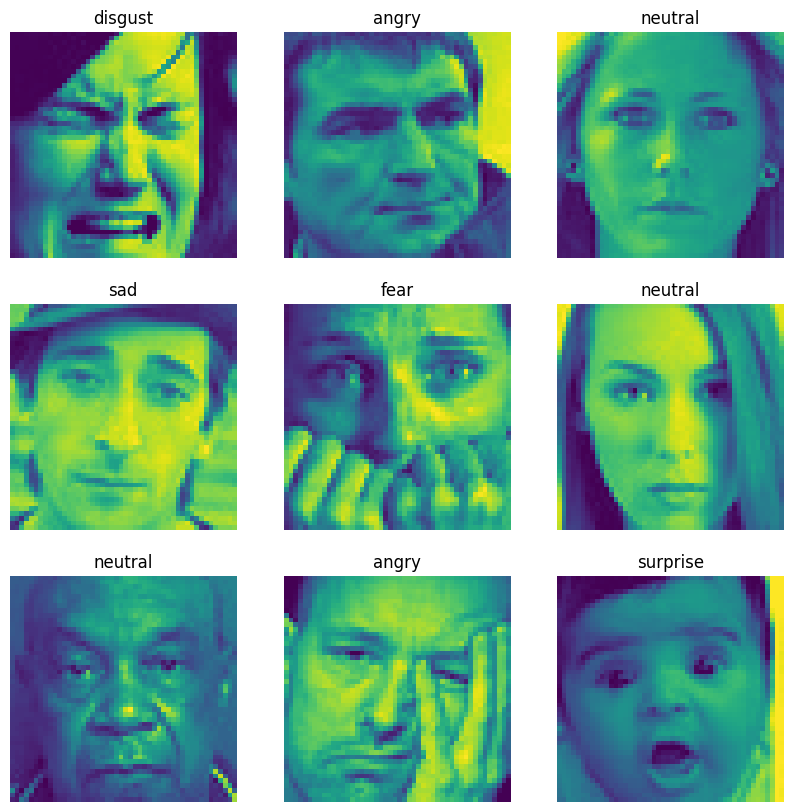

In [3]:
%pip install matplotlib seaborn
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
	for i in range(9):
		ax = plt.subplot(3, 3, i + 1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(classes_names[labels[i]])
		plt.axis("off")

plt.show()

In [4]:
# data prefecting
for batch_data, labels_batch in train_dataset:
	print(f"The shape of batch data is : {batch_data.shape}")
	print(f"The labels of shape is : {labels_batch.shape}")
	break	

The shape of batch data is : (16, 48, 48, 1)
The labels of shape is : (16,)


## ⚒️⚒️ Apply the Data AUgmentation

2025-02-28 11:39:27.538824: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


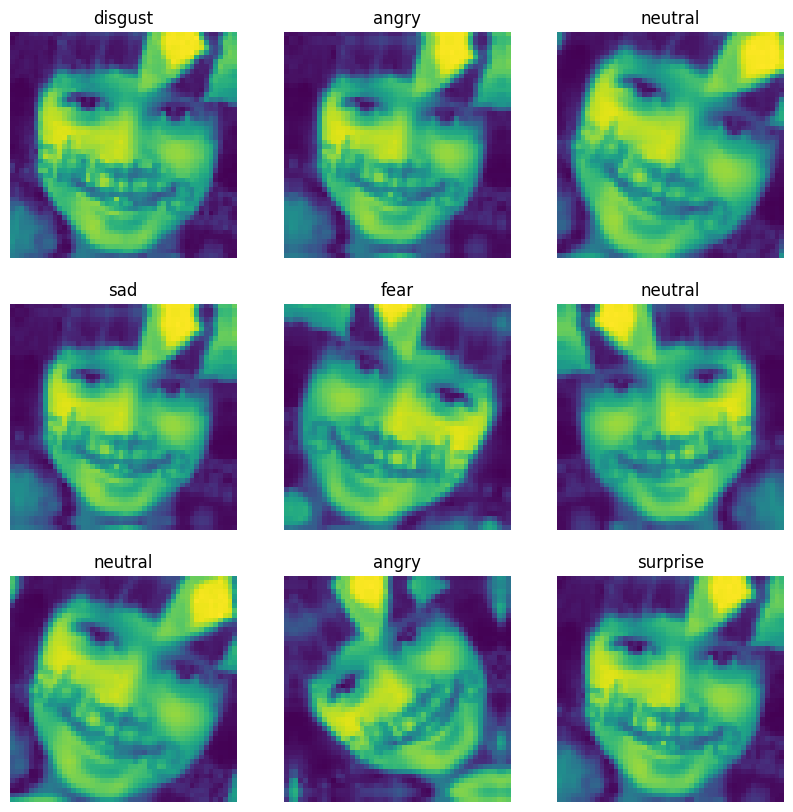

In [5]:
## using data augmentation
data_augmentation = keras.Sequential(
    [
    layers.RandomFlip("horizontal", name="flip_horizontal"),
    layers.RandomRotation(0.1, name="random_rotation"),
    layers.RandomZoom(0.1, name = "random_zoom"),
	]
)


plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(classes_names[labels[i]])
        plt.axis("off")
plt.show()

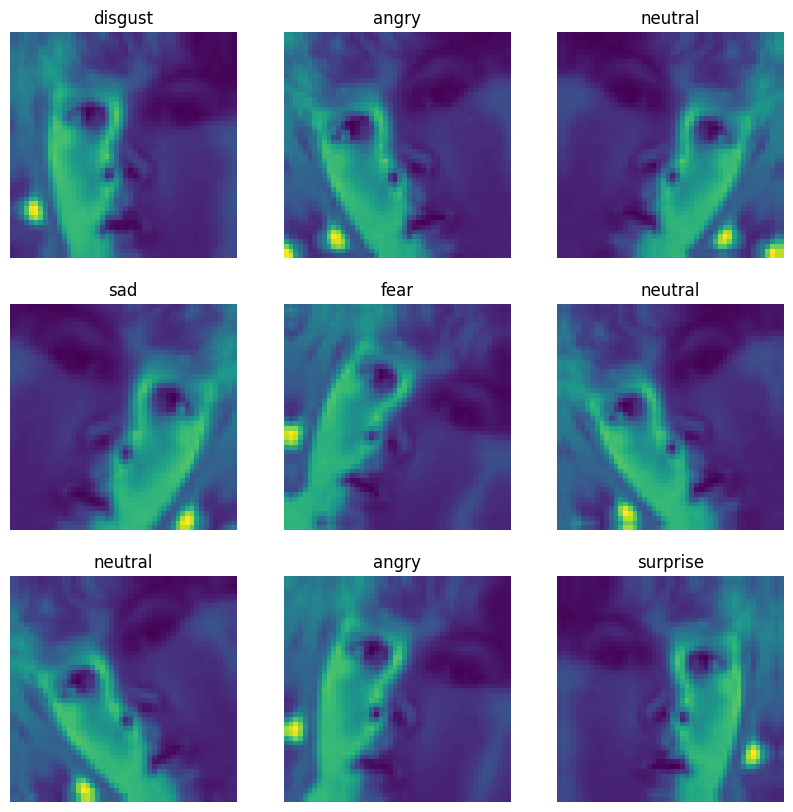

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in val_dataset.take(1):
	for i in range(9):
		augmented_images = data_augmentation(images)
		ax = plt.subplot(3, 3, i + 1)
		plt.imshow(augmented_images[0].numpy().astype("uint8"))
		plt.title(classes_names[labels[i]])
		plt.axis("off")
plt.show()

## 🔬🔬 Moodeling with the Convolutionnal Neuraal Networks (CNN)

In [7]:
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
inputs = Input(shape=(48, 48, 1))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)
# first conv block
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
# couche de maxpooling
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# second conv block
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
# couche de maxpooling
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# third conv block
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
# couche de maxpooling
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# four conv block
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(filters=256, kernel_size=3,activation='relu',padding='same')(x)
# flatten the output
x = layers.Flatten()(x)
# dropout layer
x = layers.Dropout(0.5)(x)
# second dense layer
outputs = layers.Dense(7, activation="softmax")(x)
modelV0 = Model(inputs, outputs)

modelV0.compile(
	optimizer=RMSprop(learning_rate=1e-5),
	loss="sparse_categorical_crossentropy",
	metrics=["accuracy"]
)

modelV0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 1, 1, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 979,719 (3.74 MB)

 Trainable params: 979,719 (3.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## using callbachks
callbacks = [
	keras.callbacks.ModelCheckpoint("../models/modelV0.keras",
    save_best_only=True,
    monitor="val_loss"
	),
	keras.callbacks.EarlyStopping(
	monitor="val_loss",
	patience=3,
	verbose=1,
	)
]

history = modelV0.fit(
	train_dataset,
	validation_data=val_dataset,
	epochs=100,
	callbacks=callbacks
)


Epoch 1/100
   1/1795 ━━━━━━━━━━━━━━━━━━━━ 1:48:47 4s/step - accuracy: 0.1875 - loss: 1.9469

2025-02-28 11:47:05.604569: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23369472 exceeds 10% of free system memory.
2025-02-28 11:47:05.801222: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23369472 exceeds 10% of free system memory.


   3/1795 ━━━━━━━━━━━━━━━━━━━━ 7:06 238ms/step - accuracy: 0.1632 - loss: 1.9477

2025-02-28 11:47:06.025427: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23369472 exceeds 10% of free system memory.


   4/1795 ━━━━━━━━━━━━━━━━━━━━ 7:15 243ms/step - accuracy: 0.1576 - loss: 1.9472

2025-02-28 11:47:06.346723: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23369472 exceeds 10% of free system memory.


   5/1795 ━━━━━━━━━━━━━━━━━━━━ 7:22 247ms/step - accuracy: 0.1535 - loss: 1.9469

2025-02-28 11:47:06.559295: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23369472 exceeds 10% of free system memory.


1795/1795 ━━━━━━━━━━━━━━━━━━━━ 271s 149ms/step - accuracy: 0.2260 - loss: 1.8859 - val_accuracy: 0.2513 - val_loss: 1.8171
Epoch 2/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 264s 147ms/step - accuracy: 0.2445 - loss: 1.8271 - val_accuracy: 0.2513 - val_loss: 1.8151
Epoch 3/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 370s 206ms/step - accuracy: 0.2452 - loss: 1.8226 - val_accuracy: 0.2513 - val_loss: 1.8137
Epoch 4/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 316s 176ms/step - accuracy: 0.2468 - loss: 1.8215 - val_accuracy: 0.2513 - val_loss: 1.8126
Epoch 5/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 370s 203ms/step - accuracy: 0.2477 - loss: 1.8196 - val_accuracy: 0.2513 - val_loss: 1.8100
Epoch 6/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 313s 174ms/step - accuracy: 0.2473 - loss: 1.8157 - val_accuracy: 0.2517 - val_loss: 1.8068
Epoch 7/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 348s 194ms/step - accuracy: 0.2544 - loss: 1.8103 - val_accuracy: 0.2558 - val_loss: 1.8003
Epoch 8/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 395s 220ms/step - accura

In [17]:
def plot_history(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, "bo", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  plt.show()

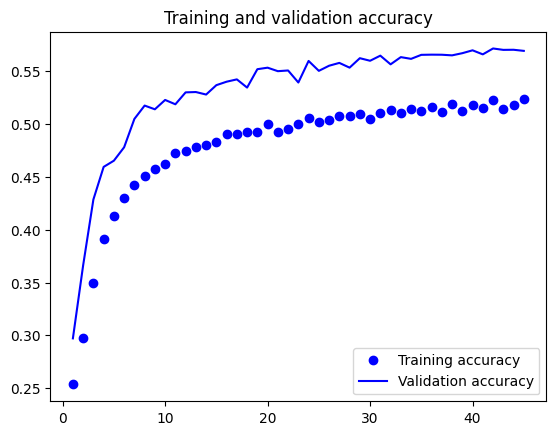

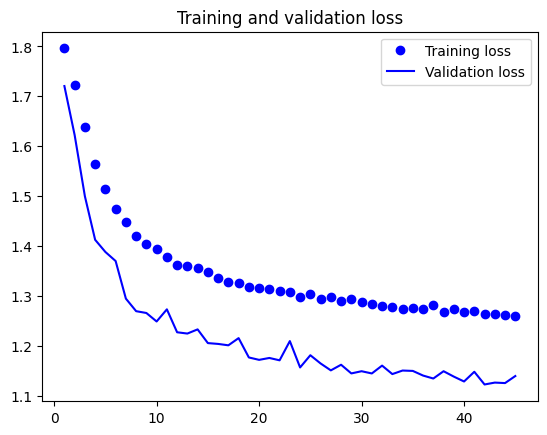

In [18]:
plot_history(history)

In [20]:
test_model = keras.models.load_model("../Systeme_detection_emotions/modelV0.h5")
test_loss_0, test_acc_0 = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc_0:.3f}")

449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5610 - loss: 1.1687
Test accuracy: 0.555


In [22]:
## saving the model	
modelV0.save("modelV0.keras", save_format="keras")

In [24]:
test_model = keras.models.load_model("../models/modelV0.keras")
test_loss_0, test_acc_0 = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc_0:.3f}")
results = test_model.predict(test_dataset)
predictions = np.argmax(results, axis=1)
print(predictions)

449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.5391 - loss: 1.1850
Test accuracy: 0.545
449/449 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step
[6 3 3 ... 3 2 0]


In [28]:
## classification report
pred_label = test_model.predict(test_dataset)
predicted_class_indices = np.argmax(pred_label, axis=1)

## true label
true_labels = []
for _, labels in test_dataset:
	true_labels.extend(labels.numpy())
## classification report
print(classification_report(true_labels, predicted_class_indices, target_names=classes_names))

449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step
              precision    recall  f1-score   support

       angry       0.13      0.14      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.11      0.14      1024
       happy       0.25      0.24      0.24      1774
     neutral       0.18      0.18      0.18      1233
         sad       0.18      0.23      0.20      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.15      0.14      7178
weighted avg       0.18      0.18      0.18      7178



In [ ]:
### leverage VGG16

from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (48, 48, 3)
)

# summary of paraameters model
conv_base.summary()

In [ ]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessing_images = VGG16.preprocess_input(images)
    features = conv_base.predict(preprocessing_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(val_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [ ]:
## identifier la dimension de l'image
train_features.shape

## modelisation de VGG16
inputs = Input(shape=())
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Flatten(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units=7, activation='softmax')(x)

modelVGG16_V1 = Model(inputs=inputs, outputs=outputs)

# model compile
modelVGG16_V1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
## summary
modelVGG16_V1.summary()

In [ ]:
## using callbacks and fitting
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath='../models/modelVGG16_V1.keras',
    save_best_only=True,
    monitor='val_loss',
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
    )
]

historyV1 = modelVGG16_V1.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    epochs=50,
    callbacks=callbacks,
)



In [ ]:
test_model = keras.models.load_model("../models/modelVGG16_V1.keras")
test_loss_1, test_acc_1 = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc_1:.3f}")

### Fine tuning the pre-trained model VGG16

In [ ]:
data_augmentation = Sequential(
    [
    layers.RandomFlip("horizontal", name='horizontal'),
    layers.RandomZoom(0.1,name="zoom"),
    layers.RandomRotation(0.2,name='rotation'),
	]
 
)

### instantiate the vgg16 model 

conv_base = VGG16(
	weights="imagenet",
	include_top=False,
)
conv_base.trainable = False
def training_model(inputs, model):
	## architecture of model custom
	#inputs = keras.Input(shape=(48,48,3))
	x = data_augmentation(inputs)
	x = keras.applications.vgg16.preprocess_input(x)
	x = conv_base(x)
	x = layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
	x = layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
	x = layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
	x = layers.MaxPooling2D(pool_size=2)(x)
	x = layers.Flatten()(x)
	x = layers.Dense(512, activation="relu")(x)
	x = layers.Dropout(0.5)(x)

	## couche dense
	outputs = layers.Dense(7, activation='softmax')(x)
	model = Model(inputs, outputs)
	## compile the mdoel oafter this
	model.compile(optimizers=RMSprop(learning_rate=1e-5),
               loss='sparse_categorical_crossentropy',
               metrics =['accuracy']
               )
	return model.summary()

modelVGG16_V2 = training_model(inputs=Input(shape=(48,48,3)), model=modelVGG16_V2)

## using callbaks

callbacks = [
	keras.callbacks.ModelCheckpoint(
		file_path='../models/model.keras',
  monitor = 'val_loss',
  save_best_model=True,
	)
]

history = modelVGG16_V2.fit(train_dataset,
                            epochs =50,
                            validation_data = val_dataset,
                            callbacks=callbacks)
